# Импорты и предопределенные функции
Непостредственно подключаем *sympy*

In [1]:
import sympy as sym

Подключаем команды *display*, *Latex* для отображения формул через латех-нотацию из кода

In [2]:
from IPython.display import display, Latex

Это только для графиков

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Отображает систему двух уравнений *sympy* в красивом виде. Это происходит через генерацию LaTeX-кода из *sympy*, вставлением ее в заранее прописаный LaTeX-шаблон.

In [4]:
def display2Deq(eq1, eq2):
    s = \
    r'''$$
    \left\{
    \begin{aligned}
        %s \\
        %s
    \end{aligned}
    \right.
    $$''' % (sym.latex(eq1).replace('=','&='), sym.latex(eq2).replace('=','&='))
    display(Latex(s))

# Простой случай: уравнение Ферхюльста

$$ y' = ry(1-y) $$

Задаем скалярные переменные

In [5]:
r,t, y0 = sym.symbols("r,t, y0")

Это специальные *sympy*-объекты типа `Symbol`

In [6]:
type(r)

sympy.core.symbol.Symbol

С ними можно составлять уравнения при помощи `Eq`. Например, вот такое:

In [7]:
sym.Eq(0, r**2 + t**2)

Eq(0, r**2 + t**2)

А это специальный sympy-объект типа `Function` от ранее заданной скалярной переменной

In [8]:
y = sym.Function("y")(t)

Теперь можно составить дифференциальное уравнение

In [10]:
eq0 = sym.Eq( y.diff(t), r*y*(1-y) ) 
eq0

Eq(Derivative(y(t), t), r*(1 - y(t))*y(t))

Вот так можно запросить его решение. Через *ics* задаются начальные условия. 
`y.subs(t, 0)` это запись для `y(0)`

In [11]:
sol0 = sym.dsolve( eq0, 
                   ics = {y.subs(t, 0): y0} )

In [12]:
sol0

Eq(y(t), 1/(1 + (1 - y0)*exp(-r*t)/y0))

Решение это тоже уравнение. Можно взять его правую часть (`.rhs`) и подставить туда что-то:

In [13]:
sol0.rhs.subs(y0, 2).subs(r, 1)

1/(1 - exp(-t)/2)

Можно превратить решение в обычную лямбда-функцию при помощи `lambdify`

In [14]:
sol_dep_t = sym.lambdify([t,r], sol0.rhs.subs(y0, 2) )

Используя лямбда-функцию, построим серию точных решений для `y0=2` при различных *r*. $t \in [0,10]$

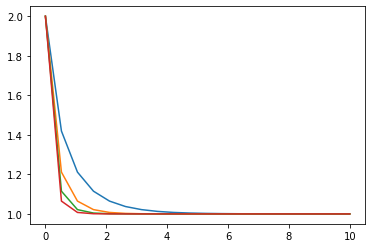

In [15]:
for rv in [1,2,3,4]:
    tt = np.linspace(0,10, 20)
    yy = sol_dep_t(tt,rv)
    plt.plot(tt, yy)

# Более сложный случай: модель Ферхюльста с фиксированным отловом

In [16]:
y0,B,t = sym.symbols("y0, B, t")


In [19]:
eq0 = sym.Eq(y.diff(t), y - y**2 -B )
eq0

Eq(Derivative(y(t), t), -B - y(t)**2 + y(t))

In [20]:
sol0 = sym.dsolve(eq0, ics={y.subs(t,0): y0})

In [21]:
sol0

Eq(t - sqrt(-1/(4*B - 1))*log(-2*B*sqrt(-1/(4*B - 1)) + sqrt(-1/(4*B - 1))/2 + y(t) - 1/2) + sqrt(-1/(4*B - 1))*log(2*B*sqrt(-1/(4*B - 1)) - sqrt(-1/(4*B - 1))/2 + y(t) - 1/2), -sqrt(-1/(4*B - 1))*log(-2*B*sqrt(-1/(4*B - 1)) + y0 + sqrt(-1/(4*B - 1))/2 - 1/2) + sqrt(-1/(4*B - 1))*log(2*B*sqrt(-1/(4*B - 1)) + y0 - sqrt(-1/(4*B - 1))/2 - 1/2))

Как мы видим, в этом решении *y* выражено от *t* в неявной форме. Однако можно получить явную зависимость `t(y)`. Для этого заменим функцию `y(t)` в выражении на скалярную переменную *z*. И найдем `t(z, y0, B)`:

In [24]:
z = sym.Symbol("z")
solexp = sym.solve(sol0.subs(y, z), t)[0]
solexp

sqrt(-1/(4*B - 1))*(-log(-2*B*sqrt(-1/(4*B - 1)) + y0 + sqrt(-1/(4*B - 1))/2 - 1/2) + log(-2*B*sqrt(-1/(4*B - 1)) + z + sqrt(-1/(4*B - 1))/2 - 1/2) + log(2*B*sqrt(-1/(4*B - 1)) + y0 - sqrt(-1/(4*B - 1))/2 - 1/2) - log(2*B*sqrt(-1/(4*B - 1)) + z - sqrt(-1/(4*B - 1))/2 - 1/2))

В данном выражении промежуточные результаты явно имеют комплексный вид, хотя в конце они должны снова стать вещественными. Проверим, подставив *B*, $y_0$, *z*. В конце выполним `evalf()`, чтобы получить конечное число:

In [28]:
testnum = solexp.subs(B, 1).subs(y0, 10).subs(z, 5).evalf()
testnum

0.114565121019032 + 1.62374802770816e-23*I

Действительно комплексная часть не в точности ноль из-за ограничной машинной точности. Поэтому нужно взять вещественную часть и превратить из *sympy*-типа в простой *float*:

In [29]:
float(sym.re(testnum))

0.1145651210190316

Построим два решения для различных *B*:

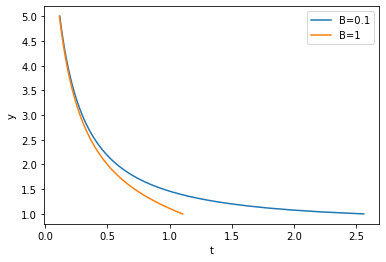

In [36]:
for BV in [0.1, 1]:
    zz = np.linspace(1,5, 100)
    tt = np.zeros(100)
    for i in range(100):
        zv = zz[i]
        tt[i] = float(sym.re(solexp.subs(B, BV).subs(y0, 10).subs(z, zv).evalf()) )
    plt.plot(tt,zz, label='B='+str(BV))
plt.legend()
_ = plt.xlabel('t')
_ = plt.ylabel('y')

# Двухмерное линейная система ОДУ

$$
\left\{
\begin{aligned}
x' &= x + y \\
y' &= 2x - py
\end{aligned}
\right.
$$

In [37]:
p,t = sym.symbols("p,t")

In [38]:
x = sym.Function("x")(t)
y = sym.Function("y")(t)

Дадим правые части отдельно (потребуется для анализа)

In [39]:
x_rate = x + y
y_rate = 2*x - p*y

In [40]:
eq1 = sym.Eq(x.diff(t), x_rate)
eq2 = sym.Eq(y.diff(t), y_rate)

Используем нашу предопределенную функцию для отображения системы совместно:

In [41]:
display2Deq(eq1,eq2)

<IPython.core.display.Latex object>

## Точные решения системы

In [42]:
x0,y0 = sym.symbols("x0, y0")

При решении системы, функции `dsolve` подается список уравнений:

In [44]:
sol = sym.dsolve([eq1, eq2],
          ics={x.subs(t,0): x0,
               y.subs(t,0): y0})

Решением системы тоже будет список:

In [45]:
display(sol[0])
display(sol[1])

Eq(x(t), -(x0*(p - sqrt(p**2 + 2*p + 9) + 1)*(p + sqrt(p**2 + 2*p + 9) + 1)/(2*(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 9)) - y0*(p + sqrt(p**2 + 2*p + 9) + 1)*(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 5)/(4*(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 9)))*exp(t*(-p + sqrt(p**2 + 2*p + 9) + 1)/2) + (x0*(p - sqrt(p**2 + 2*p + 9) + 1)*(-p**3 + p**2*(sqrt(p**2 + 2*p + 9) - 3) + p*(2*sqrt(p**2 + 2*p + 9) - 9) + 3*sqrt(p**2 + 2*p + 9) - 7)/(2*(-p**4 + p**3*(sqrt(p**2 + 2*p + 9) - 4) + p**2*(3*sqrt(p**2 + 2*p + 9) - 16) + 3*p*(3*sqrt(p**2 + 2*p + 9) - 8) + 7*sqrt(p**2 + 2*p + 9) - 27)) - y0*(p - sqrt(p**2 + 2*p + 9) + 1)*(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 5)/(2*(-p**4 + p**3*(sqrt(p**2 + 2*p + 9) - 4) + p**2*(3*sqrt(p**2 + 2*p + 9) - 16) + 3*p*(3*sqrt(p**2 + 2*p + 9) - 8) + 7*sqrt(p**2 + 2*p + 9) - 27)))*exp(-t*(p + sqrt(p**2 + 2*p + 9) - 1)/2))

Eq(y(t), -(2*x0*(p - sqrt(p**2 + 2*p + 9) + 1)/(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 9) - y0*(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 5)/(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 9))*exp(t*(-p + sqrt(p**2 + 2*p + 9) + 1)/2) + (2*x0*(-p**3 + p**2*(sqrt(p**2 + 2*p + 9) - 3) + p*(2*sqrt(p**2 + 2*p + 9) - 9) + 3*sqrt(p**2 + 2*p + 9) - 7)/(-p**4 + p**3*(sqrt(p**2 + 2*p + 9) - 4) + p**2*(3*sqrt(p**2 + 2*p + 9) - 16) + 3*p*(3*sqrt(p**2 + 2*p + 9) - 8) + 7*sqrt(p**2 + 2*p + 9) - 27) - 2*y0*(p**2 - p*(sqrt(p**2 + 2*p + 9) - 2) - sqrt(p**2 + 2*p + 9) + 5)/(-p**4 + p**3*(sqrt(p**2 + 2*p + 9) - 4) + p**2*(3*sqrt(p**2 + 2*p + 9) - 16) + 3*p*(3*sqrt(p**2 + 2*p + 9) - 8) + 7*sqrt(p**2 + 2*p + 9) - 27))*exp(-t*(p + sqrt(p**2 + 2*p + 9) - 1)/2))

Сделаем из решения две лямбда-функции:

In [46]:
xlam = sym.lambdify([t,p,x0,y0], sol[0].rhs)
ylam = sym.lambdify([t,p,x0,y0], sol[1].rhs)

Построим решения для начальных условий $(2,3)$ при различных значениях параметра *p*:

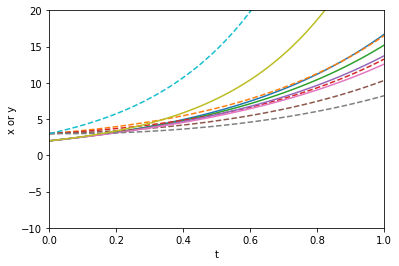

In [50]:
for pv in [0.1, 0.5, 1, 1.5, -2]:
    tt = np.linspace(0,1,100)
    xx = xlam(tt, pv, 2, 3)
    yy = ylam(tt, pv, 2, 3)

    plt.plot(tt, xx, '-')
    plt.plot(tt, yy, '--')
plt.xlim(0,1)
plt.ylim(-10,20)
_ = plt.xlabel('t')
_ = plt.ylabel('x or y')

Построим эти же решения в форме фазовых траекторий в фазовом пространстве:

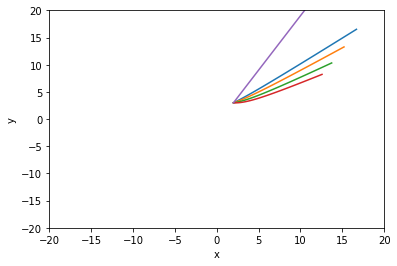

In [54]:
for pv in [0.1, 0.5, 1, 1.5, -2]:
    tt = np.linspace(0,1,100)
    xx = xlam(tt, pv, 2, 3)
    yy = ylam(tt, pv, 2, 3)

    plt.plot(xx, yy)
plt.xlim(-20,20)
plt.ylim(-20,20)
_ = plt.xlabel('x')
_ = plt.ylabel('y')

## Анализ устойчивости стационарной точки

Стационарная точка находится из решения алгебраической системы:

In [56]:
display2Deq(
    sym.Eq(0, x_rate), 
    sym.Eq(0, y_rate) )

<IPython.core.display.Latex object>

Очевидно, в данном простом случае есть только нулевой стационар.

In [58]:
sym.nonlinsolve([x_rate, y_rate], [x,y])

{(0, 0)}

Определим матрицу Якоби. Для этого используем вектор правых частей в качестве отображения. А вектор $(x, y)$ в качестве вектора переменных.

In [60]:
J = sym.Matrix([x_rate, y_rate]).jacobian(sym.Matrix([x,y]))
J

Matrix([
[1,  1],
[2, -p]])

Легко получить собственные значения и соответствующие им собственные вектора при помощи метода `eigenvects`:

In [62]:
vecs = J.eigenvects()

На выходе этот метод дает список из кортежей следующего вида:  
```
[ (lambda_1, 1, [ vec_1 ] ),
  (lambda_2, 1, [ vec_2 ] ),
  (lambda_3, 2, [ vec_3_1, vec3_2] ) ]
```

Первым в кортеже стоит собственное число, вторым - его кратность. Третьим - список собственных векторов (длины кратности). В данном случае у нас два собственных числа кратности 1.

In [63]:
vecs

[(-p/2 - sqrt(p**2 + 2*p + 9)/2 + 1/2,
  1,
  [Matrix([
   [p/4 - sqrt(p**2 + 2*p + 9)/4 + 1/4],
   [                                 1]])]),
 (-p/2 + sqrt(p**2 + 2*p + 9)/2 + 1/2,
  1,
  [Matrix([
   [p/4 + sqrt(p**2 + 2*p + 9)/4 + 1/4],
   [                                 1]])])]

Первое собственное число:

In [64]:
J.eigenvects()[0][0]

-p/2 - sqrt(p**2 + 2*p + 9)/2 + 1/2

Его кратность:

In [66]:
J.eigenvects()[0][1]

1

Его собственный вектор:

In [67]:
J.eigenvects()[0][2][0]

Matrix([
[p/4 - sqrt(p**2 + 2*p + 9)/4 + 1/4],
[                                 1]])

Построим зависимость вещественной части обоих собственных значений от *p*, чтобы понять тип стационарной точки в диапазоне $p \in (-5,5)$:

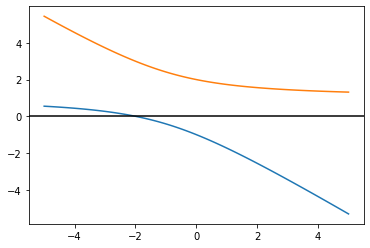

In [75]:
lam1 = sym.lambdify(p, sym.re(J.eigenvects()[0][0]) )
lam2 = sym.lambdify(p, sym.re(J.eigenvects()[1][0]) )

pp = np.linspace(-5,5,100)
plt.plot(pp, lam1(pp))
plt.plot(pp, lam2(pp))
plt.axhline(0, color='k')

Видно, что при $p < -2$ оба собственных числа больше нуля - точка неустойчива (неустойчивый узел). При $p>-2$ - собственные числа имеют разный знак (точка типа седло).